In [1]:
# Import modules
#import mpld3
%matplotlib inline
#mpld3.enable_notebook()
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
from astropy.io import ascii
import pytz
# OS interaction
import sys
import os
import glob
import re
import time
os.environ['TZ'] = 'GMT'
time.tzset()

In [2]:
# Directories
# Path to raw data
main_dir   = os.path.normpath(r'/home/nwayand/data_sets/MET/EC')
in_dir     = os.path.join(main_dir,'daily')
out_file    = os.path.join(main_dir,'netcdf','EC_daily.nc')
meta_file  = os.path.join(main_dir,'EC_stations.csv')

In [3]:
# EC format
c_header = 1 # Header lines
c_column_line = 0 # line where column names start
c_delimiter = ','
var_name_dic = {"maxT":"MaximumAirTemp","minT":"MinimumAirTemp","meanT":"DailyAvgAirTemp",
                "total_rain_mm":"p_rain","total_snow_cm":"p_snow",
                "total_precip_mm":"IncrementalPrecipitaitonA",
                "snow_on_grnd_cm":"SnowDepthA","dir_max_gust_deg":"dir_max_gust",
                "speed_max_gust_kmh":"speed_max_gust"}
units_all = {'DailyAvgAirTemp':'C',
                 'p_rain':'mm',
                 'p_snow':'cm',
                 'dir_max_gust':'deg',
                 'SnowDepthA':'cm',
                 'IncrementalPrecipitaitonA':'mm',
                 'MinimumAirTemp':'C',
                 'MaximumAirTemp':'C',
                 'speed_max_gust':'kmh'}

In [4]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'S' or direction == 'W':
        dd *= -1
    return dd;

In [5]:
# Get file in info
os.chdir(in_dir) # Move to input
content = glob.glob('*.csv') # Get list of files
num_files = len(content)

In [6]:
# Read in metadata (all stations)
metadata = pd.read_csv(meta_file,index_col='Name')
metadata['lat'] = [dms2dd(x.split('_')[0],x.split('_')[1],x.split('_')[2],x.split('_')[3]) for x in metadata['lat']]
metadata['long'] = [dms2dd(x.split('_')[0],x.split('_')[1],x.split('_')[2],x.split('_')[3]) for x in metadata['long']]

In [7]:
# Initalize stuff
c_dict = {}
stations_all=[]
variables=[]
time_index = {}

In [8]:
# Read in each file
for cfile in content:
    
    # Get current station name
    csta_ID = cfile.split('_')[0] # Take the first three letter abbreviation as the name
    csta_name = metadata.StationID[metadata.StationID == float(csta_ID)].index.tolist()[0];
    print('Processing ' + csta_name)
    stations_all.append(csta_name)
    
    # Import data to pandas dataframe
    dat = ascii.read(cfile,header_start=c_column_line,data_start=c_header,
                     delimiter=c_delimiter,exclude_names='N/A')
    datain = pd.DataFrame(dat.as_array())
    
    # Remove symbols
    try:
        datain['day'] = datain['day'].map(lambda x: re.search('[0-9]+',x).group())
    except:    
        datain['day'] = datain['day']
        
    # Remove missing
    datain.replace('LegendMM',np.NaN,inplace=True)
    datain.replace('nan',np.NaN,inplace=True)
    datain.replace('-9999',np.NaN,inplace=True)
    
    # Force to numeric
    datain = datain.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    # Fix Time
    cdate = []
    for cr in datain.index:
        try:
            cdate.append(datetime(int(datain.ix[cr,'Year']),int(datain.ix[cr,'Month']),int(datain.ix[cr,'day'])))
        except:
            # It is a bad date, so remove all data
            #print datain.ix[cr]
            datain.drop(cr,axis=0,inplace=True)


    datain['time'] = cdate
    datain['time'] = datain['time']
    datain.set_index('time',inplace=True)
    datain.drop(['day','Month','Year','heat_dd','cool_dd'],axis=1,inplace=True)
    

    ## Rename funky station names to common MVF names
    datain.rename(columns=var_name_dic, inplace=True)
    
#     # Import header info 
#     headerinfo = pd.read_csv(cfile,nrows=2,skiprows=1)
#     units = headerinfo.loc[0,:].tolist() # Grab first row of dataframe (units)
#     units = units[1:] # Remove first value which is the units of the timestamp
#     units_dic = dict(zip(datain.columns,units)) # Dictionary of variable:units for this stations
#     units_all = merge_two_dicts(units_all, units_dic) # Merge dictoinaries together (units_dic overwrites any units_all)
    
    # Loop through all variables for this station
    c_variables = datain.columns
    variables.extend(c_variables.values) # Store all variables for use latter
    for c_var in c_variables:
        c_dict[(csta_name,c_var)]        =pd.DataFrame(datain[c_var])
        c_dict[(csta_name,c_var)].columns=[c_var]
        c_dict[(csta_name,c_var)].index  = datain.index
        
    # Save time index for each station (need to fill in missing variables later)
    time_index[csta_name] = datain.index

Processing SUNDREA
Processing TINDA
Processing EMERALD
Processing ROCKY MTN HOUSE (AUT)
Processing RAMFALLS
Processing BOWVALLEY
Processing KANANASKISPOCATERRA
Processing NORDEGGCS
Processing WILDCATHILLS
Processing NAKISKARIDGETOP
Processing GOLDENA
Processing BANFF
Processing YOHO
Processing KANANASKIS
Processing OHARA
Processing KOOTENAYNPWESTGATE
Processing GOLDENAIRPORT
Processing GLACIERNPROGERSPASS


In [9]:
# Get unique variables from list variables
variables_uniq = set(variables)
variables_uniq

{'DailyAvgAirTemp',
 'IncrementalPrecipitaitonA',
 'MaximumAirTemp',
 'MinimumAirTemp',
 'SnowDepthA',
 'dir_max_gust',
 'p_rain',
 'p_snow',
 'speed_max_gust'}

In [10]:
# Extract data for each variable from the dictionary and create a xray.Dataset

ds_list = [] # Initalize list of xray Datasets (each a different variable)

# For each unique variable in the dictionary
for c_var in variables_uniq:
    print(c_var)
    all_vars={} # Initialize dictionary that only contains one variable for all stations
    # For each station
    for c_sta in stations_all:
        # Test if this varible was measured at this station
        if ((c_sta,c_var) in c_dict):
            all_vars[c_sta] = c_dict[(c_sta,c_var)]
        else: # Variable doesn't exists at this station so pad it with -9999 (needed to merge into one netcdf file)
            index_csta = time_index[c_sta]
            df_missing = pd.DataFrame(index=index_csta, columns=[c_var])
            #df_missing = df_missing.fillna(-9999)
            all_vars[c_sta] = df_missing

    # Concatenate each variable by stations
    c_obs_all = pd.concat(all_vars,axis=0,keys=stations_all)
    #c_obs_all = pd.DataFrame(c_obs_all) # not needed
    
    # Convert to xray and add to list
    ds = xr.Dataset.from_dataframe(c_obs_all)
    # Add to list and rename variables
    ds_list.append(ds.rename({'level_0':'station'}))  

DailyAvgAirTemp
p_snow
MaximumAirTemp
MinimumAirTemp
IncrementalPrecipitaitonA
speed_max_gust
dir_max_gust
SnowDepthA
p_rain


In [11]:
# Combine all variable Datasets using xray.update()
ds_all = xr.Dataset()
[ds_all.update(c_ds) for c_ds in ds_list]
ds_all

<xarray.Dataset>
Dimensions:                    (station: 18, time: 854)
Coordinates:
  * station                    (station) object 'SUNDREA' 'TINDA' 'EMERALD' ...
  * time                       (time) datetime64[ns] 2014-10-01 2014-10-02 ...
Data variables:
    DailyAvgAirTemp            (station, time) float64 5.9 1.3 3.0 10.2 7.6 ...
    p_snow                     (station, time) float64 nan nan nan nan nan ...
    MaximumAirTemp             (station, time) float64 15.7 7.4 14.4 19.5 ...
    MinimumAirTemp             (station, time) float64 -3.9 -4.9 -8.4 0.8 ...
    IncrementalPrecipitaitonA  (station, time) float64 2.0 0.0 0.0 0.7 0.0 ...
    speed_max_gust             (station, time) float64 85.0 57.0 nan 35.0 ...
    dir_max_gust               (station, time) float64 35.0 32.0 nan 6.0 nan ...
    SnowDepthA                 (station, time) float64 nan nan nan nan nan ...
    p_rain                     (station, time) float64 nan nan nan nan nan ...

In [12]:
# Add variable attributes (units), and fix variable names (remove spaces)
for cvar in ds_all.data_vars:
    print cvar
    # add units as attributes
    ds_all.get(cvar).attrs['unit']   = units_all[cvar]
    # Remove spaces in variable names
    ds_all.rename({cvar:cvar.replace(" ","")},inplace=True)

DailyAvgAirTemp
p_snow
MaximumAirTemp
MinimumAirTemp
IncrementalPrecipitaitonA
speed_max_gust
dir_max_gust
SnowDepthA
p_rain


In [13]:
# Get stations we have from metadata
A = metadata.index.tolist()
B = ds_all.station.values.tolist()
sta_missing = list(set(A) - set(B))
metadata.drop(sta_missing,inplace=True)

In [14]:
# Add meta data for each station
ds_all = ds_all.merge({'Elevation': ('station',metadata['elevation'])})
ds_all = ds_all.merge({'Lat': ('station',metadata['lat'])})
ds_all = ds_all.merge({'Lon': ('station',metadata['long'])})

In [15]:
# Make meta data coordiates from variables
ds_all.set_coords(['Elevation','Lat','Lon'], inplace=True)

<xarray.Dataset>
Dimensions:                    (station: 18, time: 854)
Coordinates:
  * station                    (station) object 'SUNDREA' 'TINDA' 'EMERALD' ...
  * time                       (time) datetime64[ns] 2014-10-01 2014-10-02 ...
    Elevation                  (station) float64 2.025e+03 1.28e+03 ...
    Lat                        (station) float64 51.36 51.43 52.08 51.65 ...
    Lon                        (station) float64 -116.3 -116.5 -115.8 -115.4 ...
Data variables:
    DailyAvgAirTemp            (station, time) float64 5.9 1.3 3.0 10.2 7.6 ...
    p_snow                     (station, time) float64 nan nan nan nan nan ...
    MaximumAirTemp             (station, time) float64 15.7 7.4 14.4 19.5 ...
    MinimumAirTemp             (station, time) float64 -3.9 -4.9 -8.4 0.8 ...
    IncrementalPrecipitaitonA  (station, time) float64 2.0 0.0 0.0 0.7 0.0 ...
    speed_max_gust             (station, time) float64 85.0 57.0 nan 35.0 ...
    dir_max_gust               (stati

In [ ]:
# Convert units to standard


In [16]:
# Export to netcdf
ds_all.to_netcdf(out_file,format='netcdf4') 

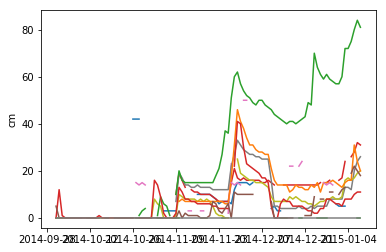

In [21]:
import matplotlib.pyplot as plt
cvar = 'SnowDepthA'
plt.plot(ds_all.time.isel(time=np.arange(0,100)),ds_all[cvar].T.isel(time=np.arange(0,100)))
plt.ylabel(ds_all[cvar].unit)